# Fluxes, boundary layers, and diffusivities (Figures 4, 5 and 6)

In [1]:
# Begin by loading the required pacakages
import h5py
import afidtools as afid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
import seaborn as sns

In [2]:
# Use seaborn to make nice plots by default
sns.set_context("paper")
sns.set_style("ticks")
UTcols = [
    "#EBBDA9", "#CF0072", "#4F2D7F", "#002C5F", "#0094B3", "#63B1E5", "#00675A", "#3F9C35",
    "#887B1B", "#FED100", "#EC7A08", "#C60C30", "#822433", "#513C40", "#616365", "#ADAFAF"
]
sns.set_palette(UTcols)
sns.color_palette(UTcols)

[(0.9215686274509803, 0.7411764705882353, 0.6627450980392157),
 (0.8117647058823529, 0.0, 0.4470588235294118),
 (0.30980392156862746, 0.17647058823529413, 0.4980392156862745),
 (0.0, 0.17254901960784313, 0.37254901960784315),
 (0.0, 0.5803921568627451, 0.7019607843137254),
 (0.38823529411764707, 0.6941176470588235, 0.8980392156862745),
 (0.0, 0.403921568627451, 0.35294117647058826),
 (0.24705882352941178, 0.611764705882353, 0.20784313725490197),
 (0.5333333333333333, 0.4823529411764706, 0.10588235294117647),
 (0.996078431372549, 0.8196078431372549, 0.0),
 (0.9254901960784314, 0.47843137254901963, 0.03137254901960784),
 (0.7764705882352941, 0.047058823529411764, 0.18823529411764706),
 (0.5098039215686274, 0.1411764705882353, 0.2),
 (0.3176470588235294, 0.23529411764705882, 0.25098039215686274),
 (0.3803921568627451, 0.38823529411764707, 0.396078431372549),
 (0.6784313725490196, 0.6862745098039216, 0.6862745098039216)]

In [3]:
# Load the time-averaged data generated by `collect_profiles.ipynb`
df = pd.read_csv("base_profiles.csv", index_col=0)
dfr = pd.read_csv("ref_profiles.csv", index_col=0)

In [4]:
# Filter out the passive temperature cases
dfa = df[df.Rρ!=0]
dfra = dfr[dfr.Rρ!=0]

## Loop over the simulations to construct lists for heat flux, salt flux, and wall shear

In dimensionless terms, these are the thermal and solutal Nusselt numbers and the friction Reynolds number:
$$
Nu_T = \frac{H}{\Delta T}\frac{\partial \overline{T}}{\partial x} , \qquad
Nu_C = \frac{H}{\Delta C}\frac{\partial \overline{C}}{\partial x} , \qquad
Re_\tau = \frac{V_\ast H}{\nu}
$$

Note that the data output by the simulation is already non-dimensionalised using $H$ for lengths, $\Delta T$ and $\Delta C$ for the scalars, and $U_f = \sqrt{g\beta \Delta C H}$ for velocity.

For convenience, in the simulations `S` always refers to the slower diffusing scalar that is evaluated on the scalar field. Therefore, for the cases where $Pr$ > $Sc$, we have to switch the scalars around to keep the data consistent.

In [5]:
Pr_list, Sc_list = [], []
Reτ_list, NuT_list, NuS_list = [], [], []

# Loop over the various Prandtl and Schmidt numbers
for Pr in dfa.Pr.unique():
    pdf = dfa[dfa.Pr==Pr]
    for Sc in pdf.Sc.unique():
        sdf = pdf[pdf.Sc==Sc]
        
        # Check whether we have switched T and S for convenience
        for Rρ in sdf.Rρ.unique():
            tdf = sdf[sdf.Rρ==Rρ]
            trdf = dfra[(dfra.Pr==Pr) & (dfra.Sc==Sc) & (dfra.Rρ==Rρ)]
            # Record friction Reynolds number
            Reτ = (tdf["vybar"][0]/tdf["x"][0]/tdf["ν"][0])**0.5
            Reτ_list.append(Reτ)
            # If Rρ<1, we haven't switched T and S
            if Rρ<1:
                Pr_list.append(Pr)
                Sc_list.append(Sc)
                NuT = (0.5 + tdf["Tbar"][0])/tdf["x"][0]
                NuS = (0.5 + trdf["Sbar"][0])/trdf["x"][0]
            # If Rρ>1, then we have switched T and S, so account for this
            else:
                Pr_list.append(Sc)
                Sc_list.append(Pr)
                NuS = (0.5 - tdf["Tbar"][0])/tdf["x"][0]
                NuT = (0.5 - trdf["Sbar"][0])/trdf["x"][0]
            # Record the two Nusselt numbers
            NuT_list.append(NuT)
            NuS_list.append(NuS)

We have stored one $yz$-plane snapshot of the scalar fields in the freely available dataset. These snapshots are located on the plane one grid point from the wall at $x=0$, and directly give us a measure of the local scalar fluxes at this time.

Here we read in the planes, as well as the grid coordinates so we can turn the scalar values into wall-normal gradients:

In [6]:
T = afid.read_cut("Sc100/Pr1", "temp", 4400, "x")
C = afid.read_cut("Sc100/Pr1", "sal", 4400, "x")
grid = afid.Grid("Sc100/Pr1")
xT0 = grid.xm[0]
xC0 = grid.xmr[0]

qT = (0.5 + T)/xT0
qC = (0.5 + C)/xC0

In preparation for plotting the figures, we define some functions to annotate the axes with labels in the corners

In [7]:
def anno_tl(ax, str):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(
        str, (l, t), xytext=(3, -3),
        textcoords="offset points",
        ha="left", va="top"
    )
    return
def anno_tr(ax, str):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(
        str, (r, t), xytext=(-3, -3),
        textcoords="offset points",
        ha="right", va="top"
    )
    return
def anno_br(ax, str, color="k"):
    l, r = ax.get_xlim()
    b, t = ax.get_ylim()
    ax.annotate(
        str, (r, b), xytext=(-3, 3),
        textcoords="offset points",
        ha="right", va="bottom", color=color
    )
    return

On the plot of Nusselt number ratio $R$, we can also plot data from the passive temperature cases, which further highlights how little impact the thermal buoyancy has on the flow. Here, we calculate $R$ for those two cases and store the data in `Rp`

In [8]:
dfp = df[df.Rρ==0]
dfrp = dfr[dfr.Rρ==0]
Rp = []
for Sc in dfp.Sc.unique():
    dftmp = dfp[dfp.Sc==Sc]
    NuTtmp = (0.5 + dftmp["Tbar"][0])/dftmp["x"][0]
    dftmp = dfrp[dfrp.Sc==Sc]
    NuStmp = (0.5 + dftmp["Sbar"][0])/dftmp["x"][0]
    Rp.append(NuTtmp/NuStmp)

## Construct figure 4 - flux ratio vs diffusivity ratio and local flux snapshots

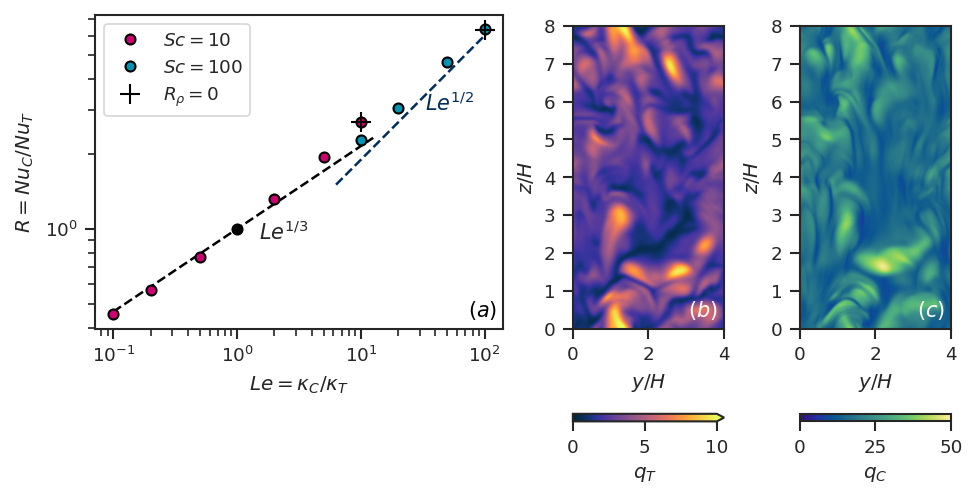

In [9]:
# Create a numpy variable for the Lewis number and the flux ratio
Sc = np.array(Sc_list)
Pr = np.array(Pr_list)
Le = Sc/Pr
R = np.array(NuS_list)/np.array(NuT_list)

# Create the figure with 3 subplots, appropriately spaced
fig, ax = plt.subplots(
    1,3,
    figsize=(6.4,3.2), constrained_layout=True, dpi=150,
    gridspec_kw={"width_ratios": [2.7,1,1]}
)

# Plot some dashed lines as example scaling relations
xx = 10**np.linspace(-1,1.1,50)
ax[0].plot(xx, xx**(1/3), 'k--')
xx = 10**np.linspace(0.8,2,50)
ax[0].plot(xx, 0.6*xx**(1/2), '--', color="C3")
ax[0].annotate('${Le}^{1/3}$', (1.5,0.9))
ax[0].annotate('${Le}^{1/2}$', (33,3), color="C3")

# Plot the majority of the flux ratio data (active temperature cases)
ax[0].loglog(Le[Sc==10], R[Sc==10], 'o', color="C1", markeredgecolor='k', label="$Sc=10$")
ax[0].loglog(Le[Sc==100], R[Sc==100], 'o', color="C4", markeredgecolor='k', label="$Sc=100$")

# Plot the passive scalar cases as crosses
ax[0].loglog(10, 1/Rp[0], '+', color="None", markeredgecolor='k', label=r"$R_\rho=0$", markersize=10)
ax[0].loglog(100, 1/Rp[1], '+', color="None", markeredgecolor='k', markersize=10)

# Plot the theoretically certain crossover point at R=1, Le=1
ax[0].loglog(1, 1, 'ko')

# Add axis labels and legend
ax[0].set_xlabel("$Le=\kappa_C/\kappa_T$")
ax[0].set_ylabel("$R=Nu_C/Nu_T$")
ax[0].legend()

# Plot planes of local scalar flux
iT = ax[1].imshow(qT.T, extent=[0,4,0,8], cmap='cmo.thermal', vmin=0, vmax=10)
iC = ax[2].imshow(qC.T, extent=[0,4,0,8], cmap='cmo.haline', vmin=0, vmax=50)

# Add axis labels to plane snaphots
for a in ax[1:]:
    a.set_xlabel('$y/H$')
    a.set_ylabel("$z/H$")

# Add colorbars
fig.colorbar(iT, ax=ax[1], orientation='horizontal', label="$q_T$", pad=0.05, extend='max')
fig.colorbar(iC, ax=ax[2], orientation='horizontal', label="$q_C$", pad=0.05)

# Add panel labels to lower right corners
anno_br(ax[0], "$(a)$")
anno_br(ax[1], "$(b)$", color='w')
anno_br(ax[2], "$(c)$", color='w')

# Save the figure
# fig.savefig("flux_ratio.pdf", dpi=300)#, transparent=True)
plt.show()

## Calculate the scalar boundary layer width as the crossover point between diffusive flux and turbulent flux

First, we define a function to compute the wall-normal derivative of the mean profiles. We need this to calculate the diffusive flux
$$
F_D = \kappa \frac{\partial \overline{T}}{\partial x}
$$

In [10]:
def ddx(A, x, BClo=0.0):
    dA = np.zeros(A.size)
    vA = np.array(A)
    xv = np.array(x)
    dA[1:-1] = (vA[2:] - vA[:-2])/(xv[2:] - xv[:-2])
    dA[0] = (vA[1] - BClo)/xv[1]
    dA[-1] = (0.0 - vA[-2])/(0.5 - xv[-2])
    return dA

Now, we calculate the two time-averaged profiles of the fluxes and locate the crossover location. For illustration, we also plot the flux profiles to a figure

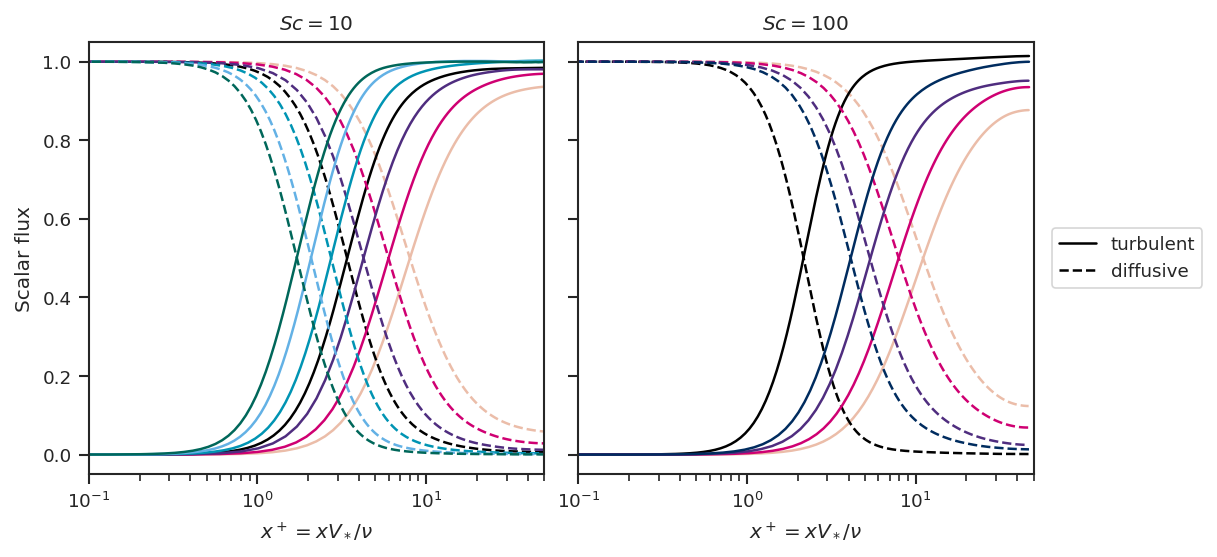

In [11]:
# Use i as a loop counter
i = 0
# Initialise list variables to store the BL widths
δT_list, δS_list = [], []

# Set line colours in advance
cols = ["C0", "C0", "C1", "C1", "C2", "C2", "C4", "C5", "C6", "C3"]

# Create a figure to plot the fluxes on
# (2 subplots, one for each Schmidt number)
fig, axs = plt.subplots(1,2, dpi=150,
                        constrained_layout=True, figsize=(8.0,3.6),
                        sharey=True
                       )

# Loop over the physical parameters (Pr, Sc, Rρ)
for Pr in dfa.Pr.unique():
    pdf = dfa[dfa.Pr==Pr]
    for Sc in pdf.Sc.unique():
        sdf = pdf[pdf.Sc==Sc]
        for Rρ in sdf.Rρ.unique():
            tdf = sdf[sdf.Rρ==Rρ]
            trdf = dfra[(dfra.Pr==Pr) & (dfra.Sc==Sc) & (dfra.Rρ==Rρ)]
            
            # Load Nusselt number to normalise flux profiles by
            NuT = NuT_list[i]
            
            # Check if Rρ<1 to see if we have switched T & S in computation
            if Rρ < 1:
                # Plot data to different axes based on Schmidt number
                if Sc==10:
                    ax = axs[0]
                else:
                    ax = axs[1]
                
                # Plot turbulent flux profile
                # (Use Re_tau to rescale grid coordinates into viscous wall units)
                ax.semilogx(tdf["x"]*Reτ_list[i], -tdf["vxT"]/tdf["κT"]/NuT, color=cols[i])
                # Compute diffusive flux profile
                dT = ddx(tdf["Tbar"],tdf["x"], BClo=-0.5)
                # Plot diffusive flux profile
                ax.semilogx(tdf["x"]*Reτ_list[i], dT/NuT, "--", color=cols[i])
                
                # Set y as the difference between the fluxes
                # Calculate flux crossover as the zero-crossing of y
                # Store the data in the lists
                y = dT + tdf["vxT"]/tdf["κT"]
                δT_list.append(np.interp(0, -y, tdf["x"]))
                dS = ddx(trdf["Sbar"],trdf["x"], BClo=-0.5)
                y = dS + trdf["vxS"]/trdf["κS"]
                δS_list.append(np.interp(0, -y, trdf["x"]))
                
            # Do the same calculations for the cases where T & S have been swapped
            else:
                ax = axs[0]
                ax.semilogx(trdf["x"]*Reτ_list[i], trdf["vxS"]/trdf["κS"]/NuT, color=cols[i])
                dT = ddx(trdf["Sbar"],trdf["x"], BClo=0.5)
                ax.semilogx(trdf["x"]*Reτ_list[i], -dT/NuT, "--", color=cols[i])
                # BL width calculation
                y = dT + trdf["vxS"]/trdf["κS"]
                δT_list.append(np.interp(0, y, trdf["x"]))
                dS = ddx(tdf["Tbar"],tdf["x"], BClo=0.5)
                y = dS + tdf["vxT"]/tdf["κT"]
                δS_list.append(np.interp(0, y, tdf["x"]))
                
            # Use single case (Pr=1) for each Schmidt number
            # Plot salt flux profiles to highlight effective Le=1 data
            if Pr==1:
                if Sc==10:
                    ax = axs[0]
                    col = "k"
                else:
                    ax = axs[1]
                    col = "k"
                NuS = NuS_list[i]
                ax.semilogx(trdf["x"]*Reτ_list[i], -trdf["vxS"]/trdf["κS"]/NuS, color=col, label="turbulent")
                dS = ddx(trdf["Sbar"],trdf["x"], BClo=-0.5)
                ax.semilogx(trdf["x"]*Reτ_list[i], dS/NuS, "--", color=col, label="diffusive")
            i += 1

# Set axis limits and labels, titles, and legeend
for j in range(2):
    axs[j].set_xlim([0.1,50])
    axs[j].set_xlabel("$x^+ = xV_*/\\nu$")
axs[0].set_ylabel("Scalar flux")
axs[0].set_ylim([-0.05,1.05])
axs[0].set_title("$Sc = 10$")
axs[1].set_title("$Sc = 100$")
axs[1].legend(bbox_to_anchor=(1.02, 0.4, 1.0, 0.2), loc='center left')

# Save the figure to file
# fig.savefig("flux_profile.svg", transparent=True)
plt.show()

In [12]:
# Record physical parameters as numpy arrays
Sc = np.array(Sc_list)
Pr = np.array(Pr_list)
Le = Sc/Pr

# Convert BL widths into viscous wall units (multiply by Re_tau)
dTp = np.array(δT_list)*np.array(Reτ_list)
dSp = np.array(δS_list)*np.array(Reτ_list)

## Create figure 5: comparison of boundary layer widths with Lewis and Prandtl number

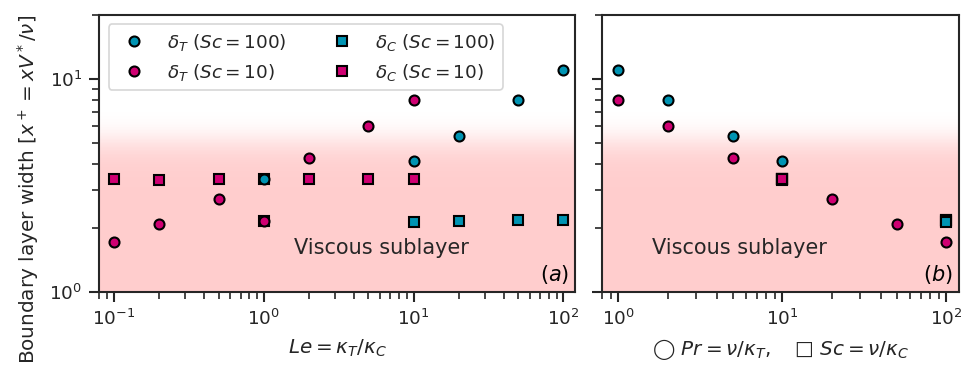

In [13]:
# Create figure with two subplots
fig, ax = plt.subplots(1,2, dpi=150,
                       figsize=(6.4,2.4), constrained_layout=True, sharey=True,
                       gridspec_kw={'width_ratios':[2,1.5]}
                      )

# Plot thermal boundary layer width against Lewis number
ax[0].loglog(Le[Sc==100], dTp[Sc==100], "o", color="C4", markeredgecolor="k", label="$\delta_T \ (Sc = 100)$")
ax[0].loglog(Le[Sc==10], dTp[Sc==10], "o", color="C1", markeredgecolor="k", label="$\delta_T \ (Sc = 10)$")

# Use mean solutal boundary layer widths to represent Le=1 data
ax[0].loglog(1.0, dSp[Sc==10].mean(), "s", color="C4", markeredgecolor="k")
ax[0].loglog(1.0, dSp[Sc==10].mean(), "o", color="C4", markeredgecolor="k")
ax[0].loglog(1.0, dSp[Sc==100].mean(), "s", color="C1", markeredgecolor="k")
ax[0].loglog(1.0, dSp[Sc==100].mean(), "o", color="C1", markeredgecolor="k")

# Plot solutal boundary layers for varying Lewis number
ax[0].loglog(Le[Sc==100], dSp[Sc==100], "s", color="C4", markeredgecolor="k", label="$\delta_C \ (Sc = 100)$")
ax[0].loglog(Le[Sc==10], dSp[Sc==10], "s", color="C1", markeredgecolor="k", label="$\delta_C \ (Sc = 10)$")

# Plot thermal BL against Prandtl number
ax[1].loglog(Pr[Sc==100], dTp[Sc==100], "o", color="C4", markeredgecolor="k")#, label="$\delta_T \ (Sc = 100)$")
ax[1].loglog(Pr[Sc==10], dTp[Sc==10], "o", color="C1", markeredgecolor="k")#, label="$\delta_T \ (Sc = 10)$")

# Plot solutal BL against Prandtl number
ax[1].loglog(Sc[Sc==100], dSp[Sc==100], "s", color="C4", markeredgecolor="k")#, label="$\delta_C \ (Sc = 100)$")
ax[1].loglog(Sc[Sc==10], dSp[Sc==10], "s", color="C1", markeredgecolor="k")#, label="$\delta_C \ (Sc = 10)$")


# Plot a shaded region to highlight the viscous sublayer x+ <= 5
y = np.linspace(1,20,100)
z = np.zeros((y.size, 1, 4))
z[:,0,3] = 0.1*(1 - np.flip(np.tanh(y-5)))
z[:,0,0] = 1.0
for a in ax:
    a.imshow(z, extent=[8e-2,120,1,20])
    a.set_ylim([1,20])
    a.annotate("Viscous sublayer", (1.6, 1.5))
    a.set_aspect('auto')
    
# Set axes limits, labels and legend
ax[0].set_xlim([8e-2,120])
ax[0].set_ylabel("Boundary layer width $[x^+ = x V^*/\\nu]$", loc='top')
ax[0].set_xlabel("$Le = \kappa_T/\kappa_C$")
ax[1].set_xlim([8e-1,120])
ax[1].set_xlabel(r"$◯ \ Pr = \nu/\kappa_T , \quad □ \ Sc = \nu/\kappa_C $")
ax[0].legend(ncol=2)

# Add panel labels
anno_br(ax[0], "$(a)$", color='k')
anno_br(ax[1], "$(b)$", color='k')

# Save figure to file
# fig.savefig("BL_widths_Pr.pdf")#svg", transparent=True)
plt.show()

## Plot and compare turbulent diffusivity profiles (figure 6)

In [14]:
# Change colour palette for this figure to reflect gradual Pr increase
sns.set_palette("cmo.haline",10)
sns.color_palette("cmo.haline",10)

[(0.1685302279919113, 0.14073088183460164, 0.6286357211183263),
 (0.06255595479554787, 0.2821282390686886, 0.6009787922718963),
 (0.07357840396611612, 0.3757710087912915, 0.5585612898846837),
 (0.15024993416559976, 0.4580115969309521, 0.5397383042732707),
 (0.20973894946144023, 0.535482279322358, 0.5337406085215398),
 (0.2573286340449816, 0.6161251617120728, 0.5223239185167129),
 (0.3194556489243874, 0.6984800979280559, 0.4892553378582481),
 (0.43744659753040943, 0.7796763669997492, 0.4230718037095968),
 (0.6287753075069072, 0.8393379672623437, 0.3597956834322973),
 (0.8320860387263339, 0.8835308362945183, 0.44033584973804246)]

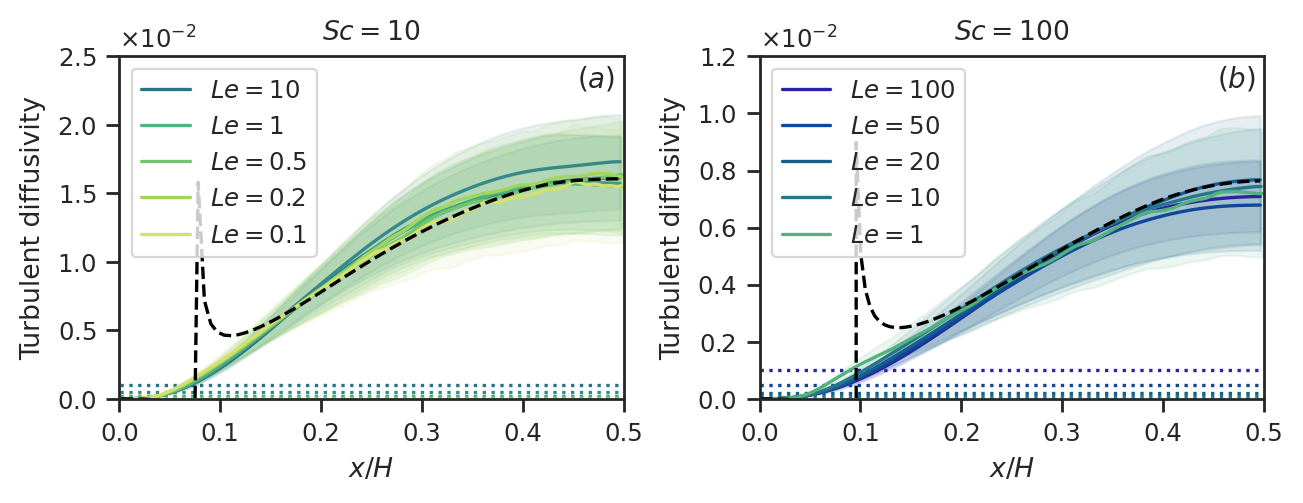

In [15]:
# Create 2 panel figure
fig, ax = plt.subplots(1,2, dpi=200, figsize=(6.4, 2.4), constrained_layout=True)

# Start with Sc==10 data
Sc = 10
# Loop over Prantl numbers
for i, Pr in enumerate([1,2,5]):
    # Select subset of data from DataFrame
    subdf = df[(df["Sc"]==Sc) & (df["Pr"]==Pr) & (df["Rρ"]!=0)]
    subdfr = dfr[(dfr["Sc"]==Sc) & (dfr["Pr"]==Pr) & (dfr["Rρ"]!=0)]
    
    # Calculate mean and standard deviation of the turbulent
    # diffusivity from the turbulent flux profiles (vxT, σvxT)
    dT = ddx(subdf["Tbar"],subdf["x"],BClo=-0.5)
    me, std = -subdf["vxT"]/dT, subdf["σvxT"]/dT
    
    # Plot profile, with shaded, translucent region to denote standard deviation range
    ax[0].fill_between(subdf["x"], me-std, me+std, alpha=0.1, color="C"+str(i+3))
    if i==0:
        ax[0].plot(subdf["x"], me, label="$Le = "+str(Sc//Pr)+"$", color="C"+str(i+3))
    else:
        ax[0].plot(subdf["x"], me, color="C"+str(i+3))
        
    # Plot constant molecular diffusivity as dotted line
    ax[0].plot(subdf["x"], subdf["κT"], ":", color="C"+str(i+3))
    
# Plot solutal diffusivity as Le=1 data
dS = ddx(subdfr["Sbar"],subdfr["x"],BClo=-0.5)
me, std = -subdfr["vxS"]/dS, subdfr["σvxS"]/dS
ax[0].fill_between(subdfr["x"], me-std, me+std, alpha=0.1, color="C6")
ax[0].plot(subdfr["x"], me, label="$Le = 1$", color="C6")
ax[0].plot(subdf["x"], subdf["κS"], ":", color="C6")

# For Pr>Sc, we have switched T & S, so also plot this data
# to the first panel
Pr = 10
for i, Sc in enumerate([20, 50, 100]):
    subdf = df[(df["Sc"]==Sc) & (df["Pr"]==Pr) & (df["Rρ"]==50)]
    subdfr = dfr[(dfr["Sc"]==Sc) & (dfr["Pr"]==Pr) & (dfr["Rρ"]==50)]
    dS = ddx(subdfr["Sbar"],subdfr["x"],BClo=-0.5)
    me, std = -subdfr["vxS"]/dS, subdfr["σvxS"]/dS
    ax[0].fill_between(subdfr["x"], me-std, me+std, alpha=0.1, color="C"+str(i+7))
    ax[0].plot(subdfr["x"], me, label="$Le = "+str(10/Sc)+"$", color="C"+str(i+7))
    ax[0].plot(subdf["x"], subdf["κS"], ":", color="C"+str(i+7))

# Choose single simulation to use for turbulent viscosity plot
subdf = df[(df["Sc"]==10) & (df["Rρ"]==0)]
# Calculate and plot turbulent viscosity with black dashed line
dv = ddx(subdf["vybar"], subdf["x"])
ax[0].plot(subdf["x"], -subdf["vxvy"]/dv, "k--")

# Set axis properties
ax[0].set_xlim([0,0.5])
ax[0].set_ylim([0,0.025])
ax[0].set_ylabel("Turbulent diffusivity")
ax[0].set_xlabel("$x/H$")
ax[0].ticklabel_format(axis='y',scilimits=(0,0), useMathText=True)
ax[0].legend()#frameon=False)
ax[0].set_title("$Sc = 10$")

# Repeat the above for Sc==100 data
Sc = 100
for i, Pr in enumerate([1,2,5,10]):
    # Select data subset
    subdf = df[(df["Sc"]==Sc) & (df["Pr"]==Pr) & (df["Rρ"]==0.02)]
    subdfr = dfr[(dfr["Sc"]==Sc) & (dfr["Pr"]==Pr) & (dfr["Rρ"]==0.02)]
    
    # Calculate diffusivity
    dT = ddx(subdf["Tbar"],subdf["x"],BClo=-0.5)
    me, std = -subdf["vxT"]/dT, subdf["σvxT"]/dT
    
    # Plot diffusivity
    ax[1].fill_between(subdf["x"], me-std, me+std, alpha=0.1, color="C"+str(i))
    ax[1].plot(subdf["x"], me, label="$Le = "+str(Sc//Pr)+"$")
    ax[1].plot(subdf["x"], subdf["κT"], ":", color="C"+str(i))

# Calculate and plot solutal diffusivity
dS = ddx(subdfr["Sbar"],subdfr["x"],BClo=-0.5)
me, std = -subdfr["vxS"]/dS, subdfr["σvxS"]/dS
ax[1].fill_between(subdfr["x"], me-std, me+std, alpha=0.1, color="C6")
ax[1].plot(subdfr["x"], me, label="$Le = 1$", color="C6")
ax[1].plot(subdf["x"], subdf["κS"], ":", color="C6")

# Calculate and plot turbulent viscosity
subdf = df[(df["Sc"]==100) & (df["Rρ"]==0)]
dv = ddx(subdf["vybar"], subdf["x"])
ax[1].plot(subdf["x"], -subdf["vxvy"]/dv, "k--")

# Set axis properties
ax[1].set_xlim([0,0.5])
ax[1].set_ylim([0,0.012])
ax[1].set_ylabel("Turbulent diffusivity")
ax[1].set_xlabel("$x/H$")
ax[1].ticklabel_format(axis='y',scilimits=(0,0), useMathText=True)
ax[1].legend()
ax[1].set_title("$Sc = 100$")

# Add panel labels
anno_tr(ax[0], "$(a)$")
anno_tr(ax[1], "$(b)$")

# Save figure to file
# fig.savefig("turbulent_diffusivity.pdf")#, transparent=True)
plt.show()